In [10]:
%matplotlib inline

In [ ]:
# 感谢弹幕提！！！弹幕老师真的太强大了！！！！

In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [12]:
import random
import torch 
from d2l import torch as d2l

In [13]:
# torch.normal(mean, std, size=None, *, out=None) -> Tensor
# torch.normal 是 PyTorch 中用于生成服从正态分布（高斯分布）随机数的函数。
# mean：正态分布的均值，可以是一个标量（单一均值）或张量（每个元素有不同的均值）。
# std：正态分布的标准差（或标准偏差），决定数据分布的宽度。同样可以是标量或张量。
# size（可选）：生成张量的形状，如果 mean 和 std 是张量，可以省略 size 参数。
# out（可选）：可指定输出张量，用于保存生成的随机数。

In [14]:
# torch.matmul(input, other, *, out=None) -> Tensor
# torch.matmul 是 PyTorch 中用于执行矩阵乘法的函数。它支持多种维度的张量相乘，行为会根据输入张量的维度自动调整

In [15]:
def synthetic_data(w,b,num_examples):
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

In [16]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [17]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.1830, -0.2486]) 
label: tensor([5.3992])


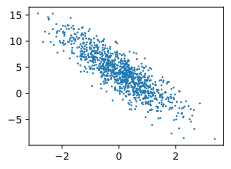

In [18]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

"""
yield 是 Python 中的一个关键字，用于定义生成器函数。和普通的 return 不同，yield 可以让函数在生成一个值后暂停执行，并在需要时继续运行，这样可以一次返回一个值，而不是一次性返回整个结果集。这种特性特别适合需要按需生成一系列数据而不占用大量内存的场景。

yield 的作用和特点
暂停函数执行：

当函数执行到 yield 语句时，会生成一个值并返回给调用方，同时暂停函数的执行状态。
下一次调用生成器时，函数会从上次暂停的地方继续执行，而不是从头开始。
生成器对象：

使用 yield 的函数会返回一个生成器对象，而不是普通的函数返回值。
生成器对象可以通过 for 循环、next() 函数等方式逐步获取每个 yield 的值。
按需计算：

生成器生成数据是“惰性”的，即只有当需要时才会计算和返回数据。
适合处理大量数据而不占用过多内存，因为生成器只在每次调用时生成当前数据，而不是将所有结果一次性放入内存。

""""

In [19]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [23]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5207,  0.4164],
        [-1.4053,  0.2834],
        [ 0.3572, -1.5844],
        [ 0.4961, -0.8757],
        [ 0.4131, -0.5952],
        [-0.1619, -0.5434],
        [ 1.3504, -1.1910],
        [-0.3305,  0.9519],
        [ 1.4612,  1.8475],
        [ 0.9474,  0.4964]]) 
 tensor([[ 3.8125],
        [ 0.4118],
        [10.2892],
        [ 8.1922],
        [ 7.0370],
        [ 5.7189],
        [10.9556],
        [ 0.2996],
        [ 0.8475],
        [ 4.4109]])


In [66]:
# 初始化模型参数

In [67]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [68]:
# 定义模型

In [69]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [70]:
# 定义损失函数

In [71]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [72]:
# 定义优化算法

In [73]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [74]:
# 训练过程

In [75]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.048169
epoch 2, loss 0.000190
epoch 3, loss 0.000049


In [44]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0048,  0.0055], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)
